# Predicting Newsletter Subscription in a Minecraft Research Server  
## What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter?

Author: Group 008-37  
Date: December 2025  
Project: UBC Computer Science – Frank Wood Research Group (Minecraft Behavioural Study)

## Introduction

This project analyzes data from a public Minecraft server run by a UBC academic team led by Professor Frank Wood. The server is designed to collect detailed behavioural data for machine learning and cognitive science research.

Players connect to a game server that records:

- Demographic information (age, gender, experience level)
- gaming behaviour (e.g., total hours played)

All in-game sessions on the research server are also logged and provide objective measures of behaviour.

Because running the server and recruiting participants is costly, the research team wants to better understand which players are engaged enough to subscribe to the research newsletter. The main questions are:

1. Can player demographics and session behaviour predict newsletter subscription?  
2. How do subscription patterns differ across behavioural player types?

## Data and Analysis Overview

### Datasets

We used two CSV files:

- `players.csv` – one row per player (196 unique players), including:
  - `hashedEmail` (anonymised identifier and join key)
  - `subscribe` (newsletter subscription: TRUE/FALSE)
  - `experience` (Beginner, Amateur, Regular, Pro, Veteran)
  - `played_hours` (self-reported lifetime hours on the server)
  - `age`, `gender`, `name` (demographics)

- `sessions.csv` – one row per gameplay session (1,535 rows), including:
  - `hashedEmail` (links sessions to players)
  - `start_time`, `end_time` (timestamps used to compute session duration)

The core analytic step was to join `players.csv` and `sessions.csv` on `hashedEmail` to obtain, for each player, both static traits (e.g., age, gender, experience) and dynamic behaviours (e.g., total playtime, number of sessions).

After cleaning and joining:

- All 196 players were retained.
- 144 players (73.5%) subscribed to the newsletter.


## Methods and Key Results

### Software and preprocessing

All analyses were implemented in R using:

- `tidyverse` for wrangling and plotting  
- `janitor` for column cleaning  
- `lubridate` for datetimes  
- `tidymodels` for predictive modelling  
- `tidyclust` for clustering  

We:

- Loaded both CSVs, cleaned column names, and converted types (e.g., `subscribe` to a logical/factor, `experience` and `gender` to factors).
- Converted `start_time` and `end_time` to datetimes and computed `session_minutes` = end − start.
- Removed implausible sessions (negative duration or longer than 24 hours).
- Verified that every session record matched a `hashedEmail` in `players`.

### Player-level engagement features

From `sessions.csv`, we aggregated to the player level. For each `hashedEmail` we computed:

- `n_sessions` – number of sessions  
- `total_minutes` – sum of `session_minutes`  
- `total_hours` – `total_minutes / 60`  
- `avg_session_minutes` – mean session length (for players with at least one session)  
- `n_active_days` – number of distinct days with at least one session  

These features were left-joined back onto `players`. Players with no sessions were assigned zeros for engagement metrics. This created a single analytic dataset combining demographics, self-reports, and behavioural logs.


### Descriptive statistics

**Overall subscription rate**

- 73.5% of players subscribed to the newsletter, so subscription is the majority outcome.

**Subscription by experience**

Grouped by `experience`, we observed:

- Regular: ≈ 80.6% subscribed; highest mean self-reported played hours (~18.2 hours).
- Beginner: ≈ 77.1% subscribed; much lower mean played hours (~1.25 hours).
- Amateur and Pro: ≈ 71.4% subscribed.
- Veteran: ≈ 68.8% subscribed; lowest mean played hours (~0.65 hours).

Thus, Regular (mid-skill) and Beginner (new) players are especially likely to subscribe, while Veterans subscribe somewhat less often.


### Engagement vs subscription

Using the joined player–engagement table:

- Subscribers played about 528 minutes (~8.8 hours) across roughly 10 sessions on average.
- Non-subscribers played about 39 minutes (~0.65 hours) across roughly 2 sessions on average.

Plots of `total_minutes` and `n_sessions` by `subscribe` show clear differences: subscribers are much more engaged on average. However, there is overlap in the distributions, so behaviour alone does not perfectly separate subscribers from non-subscribers.


### Accuracy of self-reported playtime

To compare survey and log-based hours, we:

- Restricted to players with at least one recorded session.
- Computed Pearson correlation between:
  - `played_hours` (survey)
  - `total_hours` (from logs)

Results:

- Correlation r ≈ 0.99, even when focusing on players with both `played_hours > 0` and `total_hours > 0`.

A scatterplot of `played_hours` vs `total_hours` aligned closely to the 1:1 line, indicating that players’ self-reported hours are extremely accurate in this dataset.


### Demographics

**Age and subscription**

- Non-subscribers: mean age ≈ 23.8 years  
- Subscribers: mean age ≈ 20.2 years  

Subscribers tend to be somewhat younger.

**Gender and “Prefer not to say”**

- Players who chose “Prefer not to say” for gender (about 11 people) had a subscription rate ≈ 36%.
- This is much lower than the overall subscription rate (~73.5%).

This suggests that stronger privacy concerns may be linked to lower willingness to opt into the newsletter.


### Predictive modelling (KNN)

We trained a K-nearest neighbours classifier to predict `subscribe` (yes/no) using:

- Demographic features: `age`, `gender`, `experience`  
- Behavioural features: `n_sessions`, `total_minutes`, `avg_session_minutes`, `n_active_days`, `played_hours`  

Using `tidymodels`, we:

- Created a recipe to one-hot encode categorical variables and standardise numeric predictors.
- Split the data into training and test sets (75% train, 25% test), stratified by `subscribe`.
- Used k-fold cross-validation on the training set to tune the number of neighbours.
- Evaluated performance with accuracy and confusion matrices, and compared against a baseline model that always predicts “subscribe”.

Results:

- The tuned KNN model achieved moderate accuracy, only slightly better than the majority-class baseline.
- It captured some structure (e.g., correctly identifying many subscribers) but still misclassified a substantial number of non-subscribers, and some subscribers.

This indicates that, although subscription relates to engagement and demographics, these features alone are not sufficient for highly accurate individual-level prediction.


### Cluster analysis of player behaviour

To examine behavioural “types” without using subscription directly, we performed K-means clustering (via `tidyclust`) on standardised engagement features such as `n_sessions` and `total_minutes`.

A simple two-cluster solution effectively highlighted the concentration of engagement:

- Core cluster (highly engaged)
- Casual cluster (low engagement)

Additional runs with 3–4 clusters yielded similar qualitative conclusions.

**Engagement concentration**

- Core players:
  - About 3% of the user base
  - Accounted for roughly 76% of total minutes played
  - Played frequently and for long sessions (“whales”)

- Casual players:
  - About 97% of the user base
  - On average, played for less than 2 total hours in the dataset

Scatterplots of `total_minutes` vs `n_sessions` coloured by cluster showed the Core cluster clearly separated from the Casual majority.

**Subscription by cluster**

Overlaying subscription:

- Core cluster: subscription rate ≈ 100% (every Core player subscribed)
- Casual cluster: subscription rate ≈ 73%

Thus, very high engagement almost guarantees subscription, but lower engagement does not prevent it—many casual players still subscribe.


## Discussion

### Summary of findings

Across analyses, several patterns emerge:

- Subscription is common: 73.5% of players subscribe.
- Experience matters modestly: Regular and Beginner players subscribe most; Veterans subscribe least, though still at a relatively high rate.
- Engagement is strongly related to subscription: subscribers play far more (about 8–9 hours vs about half an hour) and have more sessions.
- Engagement is highly concentrated: a tiny Core cluster ~3% accounts for most playtime ~76% and is fully subscribed.
- Self-reported hours are extremely accurate (r ≈ 0.99 with log-based hours).
- Subscribers are younger on average, and players choosing “Prefer not to say” for gender are much less likely to subscribe.
- A KNN model based on available features performs only slightly better than a trivial majority baseline.

Taken together, these results show strong relationships in averages (especially between engagement and subscription), but they do not yield a simple rule that perfectly predicts individual subscription decisions.


### Expectations vs reality

We expected that:

- More engaged players would be more likely to subscribe.
- Experience level might shape subscription patterns.
- Self-reports of playtime would be somewhat noisy.

The data confirmed and sharpened these expectations:

- Highly engaged “power users” are almost guaranteed to subscribe; the difference between subscribers and non-subscribers (more than 10× playtime on average) is larger than anticipated.
- Experience patterns are nuanced: Regular and Beginner players subscribe at high rates, while Veterans subscribe somewhat less often—a departure from a simple “more experienced → more likely to subscribe” story.
- Self-reported playtime was much more accurate than expected.

At the same time, predictive modelling revealed no simple behavioural cutoff where “more than X hours” guarantees subscription. There is overlap between groups, and even some active players do not subscribe.


### Practical implications

For the research team, the findings suggest:

- Broad appeal: because subscription rates are high across most player types, it is not necessary to heavily target a single experience group for recruitment.
- Behaviour-based prompts: given the strong link between engagement and subscription, subscription prompts could be triggered after simple behavioural thresholds, such as:
  - Reaching a third session, or
  - Surpassing 2 hours of total playtime.
- Focus of effort: trying to convert very low-engagement or strongly privacy-sensitive users may yield limited returns and could risk eroding trust if outreach feels intrusive.
- Simpler systems may suffice: since KNN only slightly outperforms a majority baseline, complex personalised recommendation systems for subscriptions may not be justified; transparent, low-friction opt-in mechanisms are likely adequate.
- Retention over micro-targeting: investing in improving overall engagement (e.g., content quality, community features, reasons to return) may be more effective than fine-grained targeting based on small demographic differences.


### Future directions

Several questions remain:

- Why do some Veterans and Pros subscribe less, despite their experience? Are they bored by the server content or motivated differently?
- How can privacy and trust be improved, especially for players who withhold gender information?
- What is the causal direction between engagement and subscription: does subscribing increase commitment, or do engaged players simply choose to subscribe?
- Would richer behavioural features (e.g. specific in-game actions, social interactions) noticeably improve prediction?
- How do these patterns generalise to other servers or games?


Addressing these questions would require additional data and more advanced experimental designs, but this initial analysis provides a strong foundation for understanding engagement in game-based research.


In [73]:
library(tidyverse)
library(tidyclust)
library(kknn)
library(lubridate)
library(janitor)
library(GGally)
library(tidymodels)

set.seed(123)  # for reproducibility

In [38]:
# 1. Load data


players_raw  <- read_csv("players(1).csv",  show_col_types = FALSE)
sessions_raw <- read_csv("sessions(1).csv", show_col_types = FALSE)

# Clean column names for consistency (snake_case)
players  <- players_raw  |> clean_names()
sessions <- sessions_raw |> clean_names()

# Quick peek at the structure
glimpse(players)
glimpse(sessions)


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashed_email <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashed_email        <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [39]:
players_vars <- tibble(
  Variable = names(players),
  Description = c(
    "experience" = "Player skill level (Factor: Beginner to Pro)",
    "subscribe" = "Subscription status (boolean: TRUE/FALSE)",
    "hashedEmail" = "Anonymized unique ID (character)",
    "played_hours" = "Total hours played (numeric)",
    "name" = "Player name (character)",
    "gender" = "Self-reported gender (factor)",
    "Age" = "Age in years (numeric)"
  )
)
players_vars

Variable     Description                                 
experience   experience   Player skill level (Factor: Beginner to Pro)
subscribe    subscribe    Subscription status (boolean: TRUE/FALSE)   
hashedEmail  hashed_email Anonymized unique ID (character)            
played_hours played_hours Total hours played (numeric)                
name         name         Player name (character)                     
gender       gender       Self-reported gender (factor)               
Age          age          Age in years (numeric)

In [40]:
sessions_vars <- tibble(
  Variable = names(sessions),
  Description = c(
    "Anonymized ID linking to players (character)",
    "Session start timestamp DD/MM/YYYY HH:MM (character)",
    "Session end timestamp DD/MM/YYYY HH:MM (character)",
    "Unix timestamp in milliseconds (numeric)",
    "Unix timestamp in milliseconds (numeric)"
  )
)


We now transform the raw tables into a single per-player dataset (player_df) suitable for modelling and visualization.

In [41]:
## 2. Clean & wrangle into per-player features

# 2.1 Clean players table

players <-
  players |>
  mutate(
    age          = as.numeric(age),
    played_hours = as.numeric(played_hours),
    experience   = factor(experience),
    gender       = factor(gender),
    # subscribe is logical or "TRUE"/"FALSE" in the CSV
    subscribe    = as.logical(subscribe),
    subscribe    = factor(subscribe, levels = c(FALSE, TRUE),
                          labels = c("No", "Yes"))
  )

Ensure that numeric variables are numeric, convert categorical variables to factors, and turn the subscription indicator into a human-readable factor ("Yes"/"No")

In [42]:
# 2.2 Clean sessions & compute per-session duration

sessions <-
  sessions |>
  mutate(
    # timestamps like "30/06/2024 18:12" -> turns it into day-month-year hour:minute
    start_dt = dmy_hm(start_time),
    end_dt   = dmy_hm(end_time),
    session_minutes = as.numeric(difftime(end_dt, start_dt, units = "mins")),
    session_date    = as_date(start_dt)
  ) |>
  # filter out impossible or missing sessions
  filter(
    !is.na(session_minutes),
    session_minutes > 0,
    session_minutes <= 24 * 60
  )

We parse timestamps, compute session duration in minutes, extract session dates, and filter out impossible sessions (negative duration, extremely long sessions, missing values).

In [43]:
# 2.3 Aggregate sessions to player level

sessions_player <-
  sessions |>
  group_by(hashed_email) |>
  summarise(
    n_sessions             = n(),
    total_minutes          = sum(session_minutes, na.rm = TRUE),
    avg_session_minutes    = mean(session_minutes, na.rm = TRUE),
    median_session_minutes = median(session_minutes, na.rm = TRUE),
    sd_session_minutes     = sd(session_minutes, na.rm = TRUE),
    active_days            = n_distinct(session_date),
    .groups                = "drop"
  )

We now compute per-player summary statistics from the sessions table:

n_sessions: number of sessions

total_minutes: total minutes played

avg_session_minutes, median_session_minutes, sd_session_minutes

active_days: number of distinct days with at least one session

In [44]:
# 2.4 Join players and behaviours & make more features

player_df <-
  players |>
  left_join(sessions_player, by = "hashed_email") |>
  mutate(
    n_sessions    = replace_na(n_sessions, 0),
    total_minutes = replace_na(total_minutes, 0),
    active_days   = replace_na(active_days, 0),
    total_hours   = total_minutes / 60
  ) |>
  mutate(
    active_days       = na_if(active_days, 0),      # 0 days → NA
    sessions_per_day  = n_sessions / active_days   # 0/NA → NA
  )


We join the per-player session features to the survey data, fill missing values with zeros where appropriate, and derive:

total_hours = total_minutes / 60

sessions_per_day = n_sessions / active_days

3. Exploratory Data Analysis

We start by characterizing subscription rates, behavioural patterns, and relationships among variables.

In [45]:
# 3.1 Overall subscription rate

overall_sub_rate <- mean(player_df$subscribe == "Yes", na.rm = TRUE)

overall_sub_rate_summary <- tibble(
  overall_subscription_rate = round(overall_sub_rate, 3)
)
overall_sub_rate_summary

overall_subscription_rate
1 0.735

This table gives the overall fraction of players who chose to subscribe to the newsletter.
Overall, approximately 73.5% of players subscribed to the newsletter.

In [46]:
# 3.2 By experience (player type) ------------------------

analysis_by_experience <-
  player_df |>
  group_by(experience) |>
  summarise(
    n_players         = n(),
    prop_subscribe    = mean(subscribe == "Yes", na.rm = TRUE),
    mean_age          = mean(age, na.rm = TRUE),
    mean_played_hours = mean(played_hours, na.rm = TRUE),
    mean_total_hours  = mean(total_hours, na.rm = TRUE),
    mean_n_sessions   = mean(n_sessions, na.rm = TRUE),
    mean_avg_session  = mean(avg_session_minutes, na.rm = TRUE),
    .groups           = "drop"
  ) |>
  arrange(desc(prop_subscribe))
analysis_by_experience

experience n_players prop_subscribe mean_age mean_played_hours
1 Regular    36        0.8055556      22.02857 18.2083333       
2 Beginner   35        0.7714286      21.65714  1.2485714       
3 Amateur    63        0.7142857      21.36508  6.0174603       
4 Pro        14        0.7142857      16.92308  2.6000000       
5 Veteran    48        0.6875000      20.95833  0.6479167       
  mean_total_hours mean_n_sessions mean_avg_session
1 19.9870370       14.388889       34.99109        
2  1.4919048        3.028571       35.39145        
3  7.1547619       13.000000       29.52310        
4  2.9059524        2.785714       40.11616        
5  0.7552083        1.062500       29.60247

This table shows, for each experience level, how many players are in that group, what fraction subscribe, and their average age and play metrics

In [47]:
# 3.3 Subscribers vs non-subscribers

analysis_by_subscribe <-
  player_df |>
  group_by(subscribe) |>
  summarise(
    n_players             = n(),
    mean_age              = mean(age, na.rm = TRUE),
    mean_played_hours     = mean(played_hours, na.rm = TRUE),
    mean_total_hours      = mean(total_hours, na.rm = TRUE),
    mean_n_sessions       = mean(n_sessions, na.rm = TRUE),
    mean_avg_session      = mean(avg_session_minutes, na.rm = TRUE),
    mean_sessions_per_day = mean(sessions_per_day, na.rm = TRUE),
    .groups               = "drop"
  )
analysis_by_subscribe

subscribe n_players mean_age mean_played_hours mean_total_hours
1 No         52       23.7500  0.5019231         0.6419872       
2 Yes       144       20.1831  7.7756944         8.7920139       
  mean_n_sessions mean_avg_session mean_sessions_per_day
1 1.980769        27.38891         1.190625             
2 9.930556        34.27394         1.238075

In [48]:
# 3.4 Correlations with subscription

corr_data <-
  player_df |>
  mutate(
    subscribe_num = as.numeric(subscribe == "Yes")
  )

corr_data_complete <-
  corr_data |>
  select(
    subscribe_num,
    age,
    played_hours,
    total_hours,
    n_sessions,
    avg_session_minutes,
    sessions_per_day
  ) |>
  drop_na()

corr_summary <-
  corr_data_complete |>
  summarise(
    cor_age              = cor(subscribe_num, age),
    cor_played_hours     = cor(subscribe_num, played_hours),
    cor_total_hours      = cor(subscribe_num, total_hours),
    cor_n_sessions       = cor(subscribe_num, n_sessions),
    cor_avg_session_min  = cor(subscribe_num, avg_session_minutes),
    cor_sessions_per_day = cor(subscribe_num, sessions_per_day)
  )
corr_summary


cor_age    cor_played_hours cor_total_hours cor_n_sessions
1 -0.1577074 0.1429478        0.1451231       0.1320095     
  cor_avg_session_min cor_sessions_per_day
1 0.09978054          0.04842227

Each correlation coefficient ranges from -1 to 1:

Values near 0: weak linear relationship.

Positive values: higher values of the predictor are associated with higher probability of subscription.

Negative values: higher predictor values are associated with lower subscription probability.

4. Visualizations

We now graph key relationships. Each figure includes a caption and, where needed, a legend.

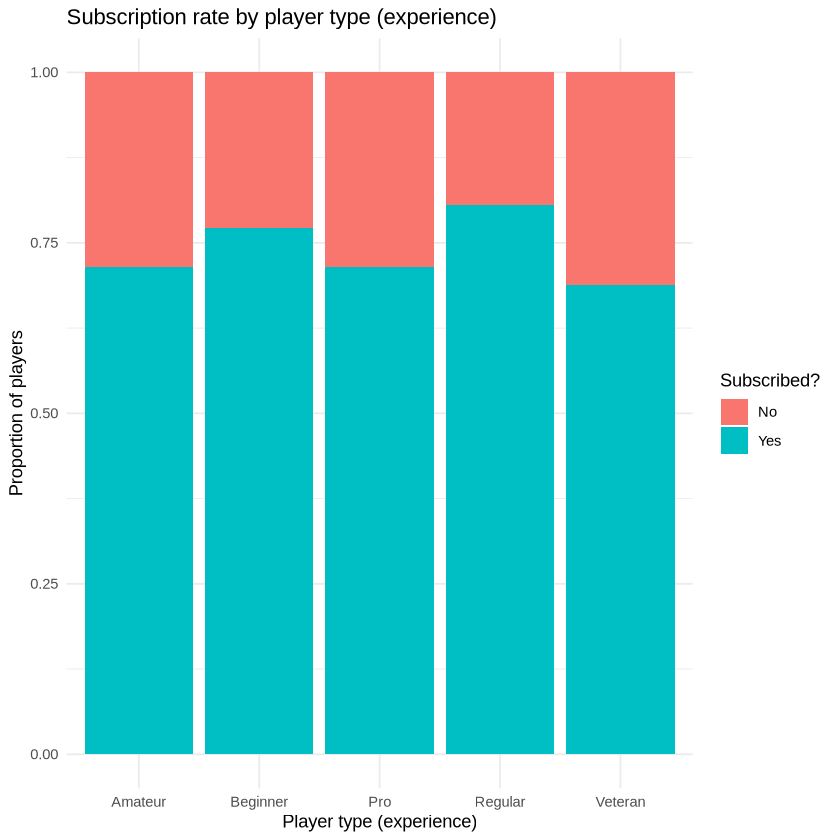

In [49]:
# 4.1 Subscription rate by experience 

subscription_by_experience_plot <-
  player_df |>
  ggplot(aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(
    title = "Subscription rate by player type (experience)",
    x     = "Player type (experience)",
    y     = "Proportion of players",
    fill  = "Subscribed?"
  ) +
  theme_minimal()

subscription_by_experience_plot

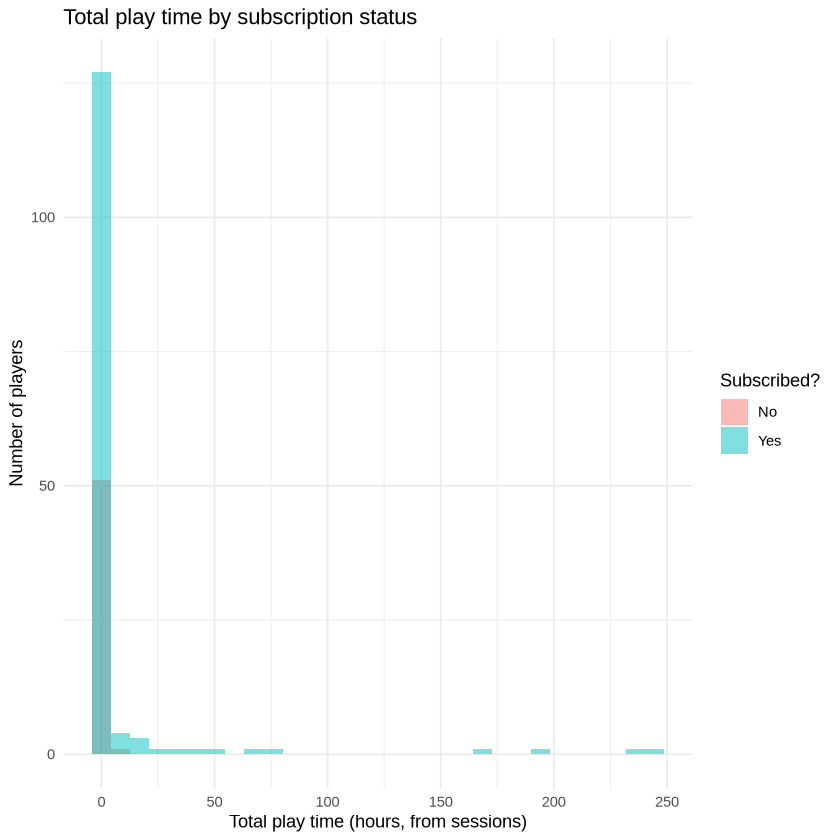

In [50]:
# 4.2 Distribution of total hours by subscription

total_hours_by_subscription_plot <-
  player_df |>
  ggplot(aes(x = total_hours, fill = subscribe)) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 30) +
  labs(
    title = "Total play time by subscription status",
    x     = "Total play time (hours, from sessions)",
    y     = "Number of players",
    fill  = "Subscribed?"
  ) +
  theme_minimal()
total_hours_by_subscription_plot

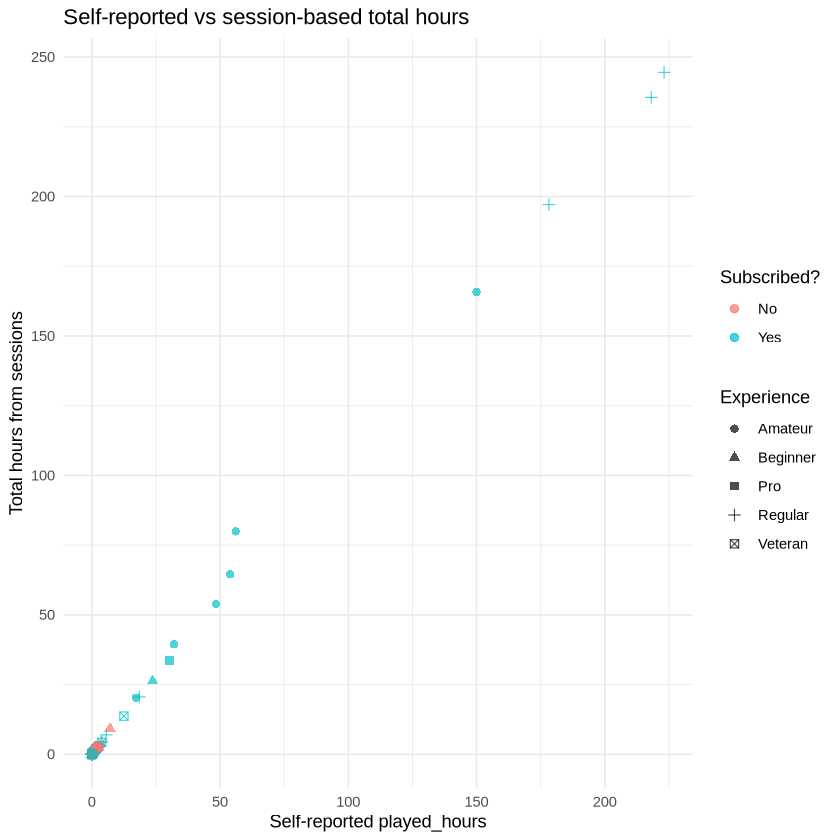

In [51]:
# 4.3 Self-reported vs session-based total hours ---------

self_vs_session_hours_plot <-
  player_df |>
  ggplot(
    aes(
      x      = played_hours,
      y      = total_hours,
      colour = subscribe,
      shape  = experience
    )
  ) +
  geom_point(alpha = 0.7, size = 2) +
  labs(
    title  = "Self-reported vs session-based total hours",
    x      = "Self-reported played_hours",
    y      = "Total hours from sessions",
    colour = "Subscribed?",
    shape  = "Experience"
  ) +
  theme_minimal()

self_vs_session_hours_plot

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


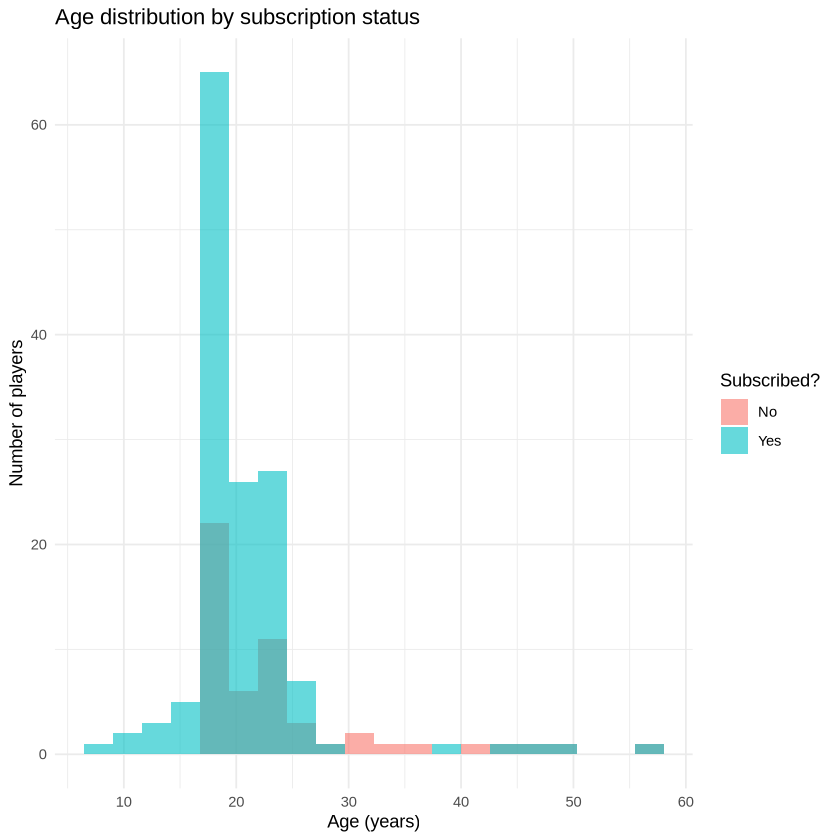

In [52]:
# 4.4 Age vs Subscription status

age_by_subscribe_plot <-
  player_df |>
  ggplot(aes(x = age, fill = subscribe)) +
  geom_histogram(alpha = 0.6, bins = 20, position = "identity") +
  labs(
    title = "Age distribution by subscription status",
    x     = "Age (years)",
    y     = "Number of players",
    fill  = "Subscribed?"
  ) +
  theme_minimal()
age_by_subscribe_plot

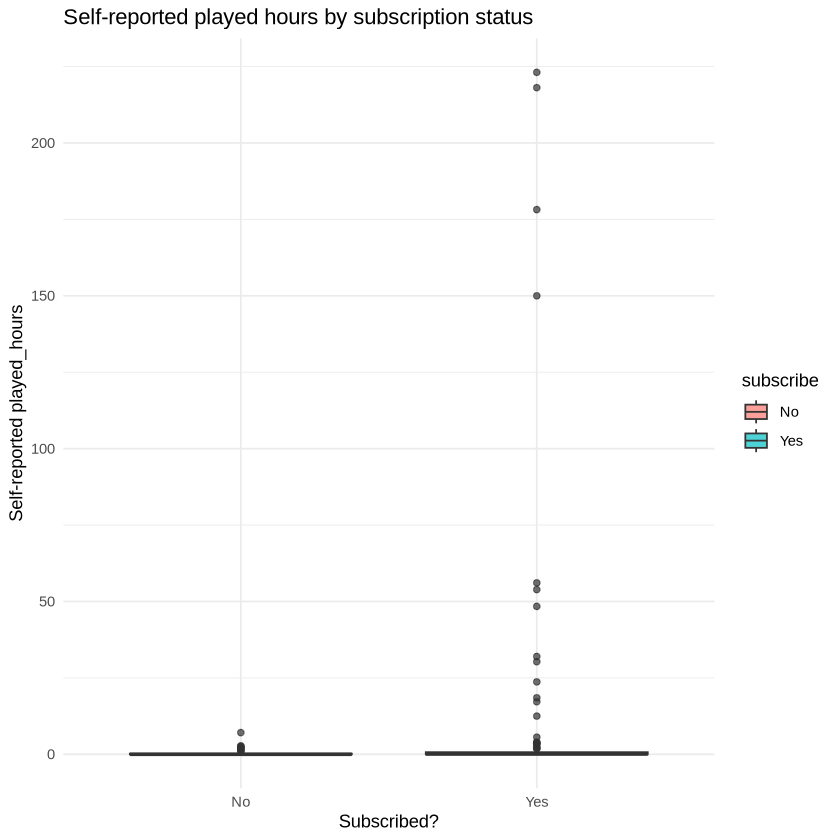

In [53]:
# 4.5 Played hours vs subscription status
played_hours_box_by_subscribe_plot <-
  player_df |>
  ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Self-reported played hours by subscription status",
    x     = "Subscribed?",
    y     = "Self-reported played_hours"
  ) +
  theme_minimal()
played_hours_box_by_subscribe_plot

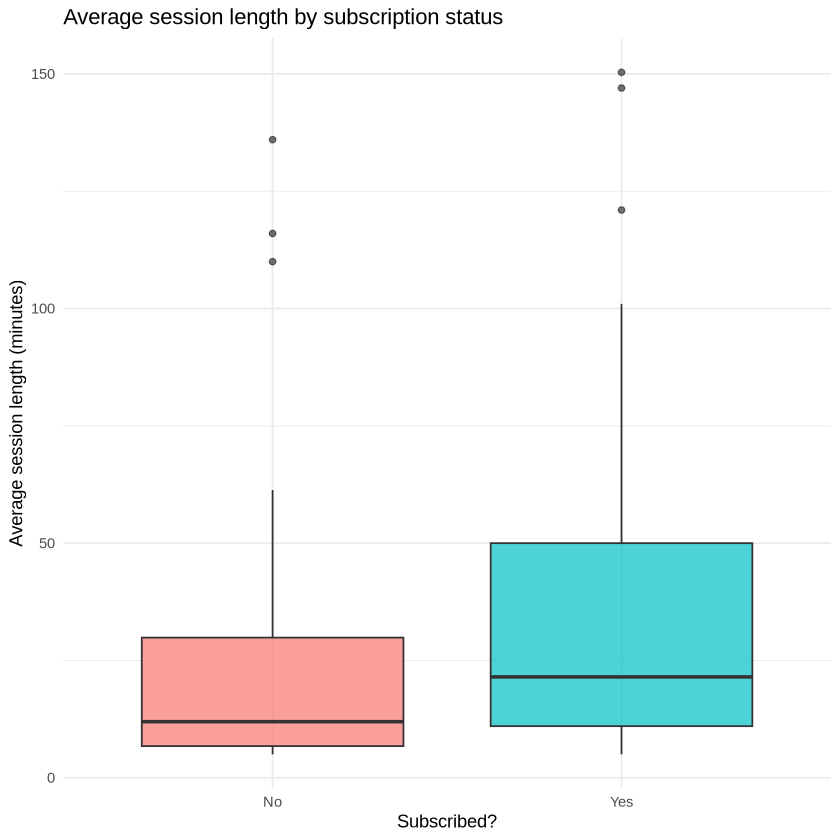

In [54]:
# 4.6 Average session length by subscription status
avg_session_by_subscribe_plot <-
  player_df |>
  filter(!is.na(avg_session_minutes)) |>
  ggplot(aes(x = subscribe, y = avg_session_minutes, fill = subscribe)) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Average session length by subscription status",
    x     = "Subscribed?",
    y     = "Average session length (minutes)"
  ) +
  theme_minimal() +
  theme(legend.position = "none")
avg_session_by_subscribe_plot

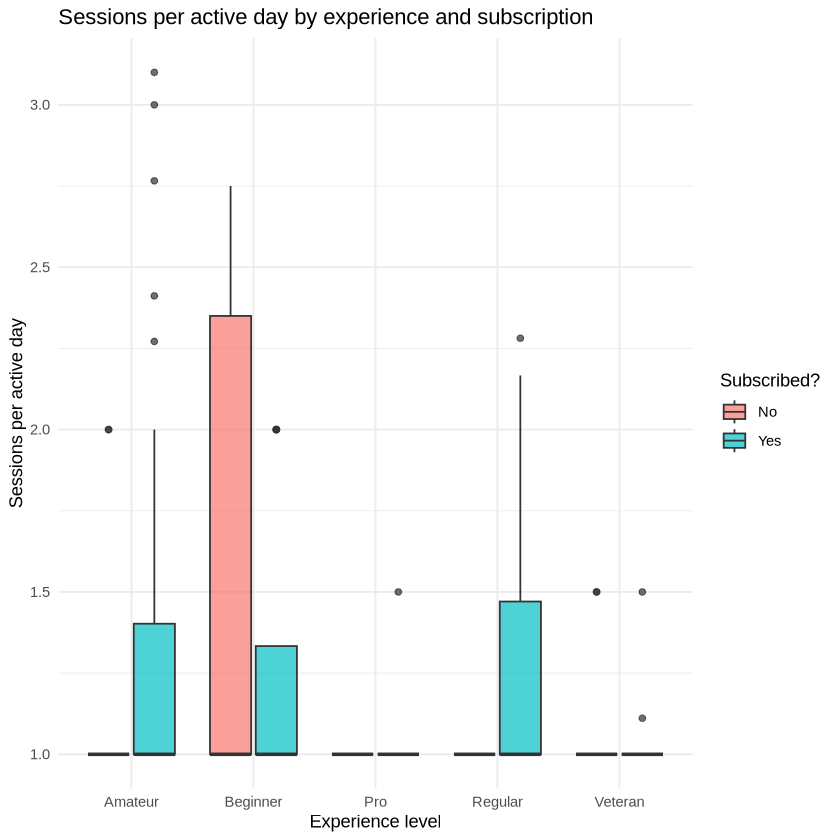

In [55]:
# 4.7 Sessions per day vs experience
sessions_per_day_by_experience_plot <-
  player_df |>
  filter(!is.na(sessions_per_day)) |>
  ggplot(
    aes(
      x      = experience,
      y      = sessions_per_day,
      fill   = subscribe
    )
  ) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Sessions per active day by experience and subscription",
    x     = "Experience level",
    y     = "Sessions per active day",
    fill  = "Subscribed?"
  ) +
  theme_minimal()
sessions_per_day_by_experience_plot

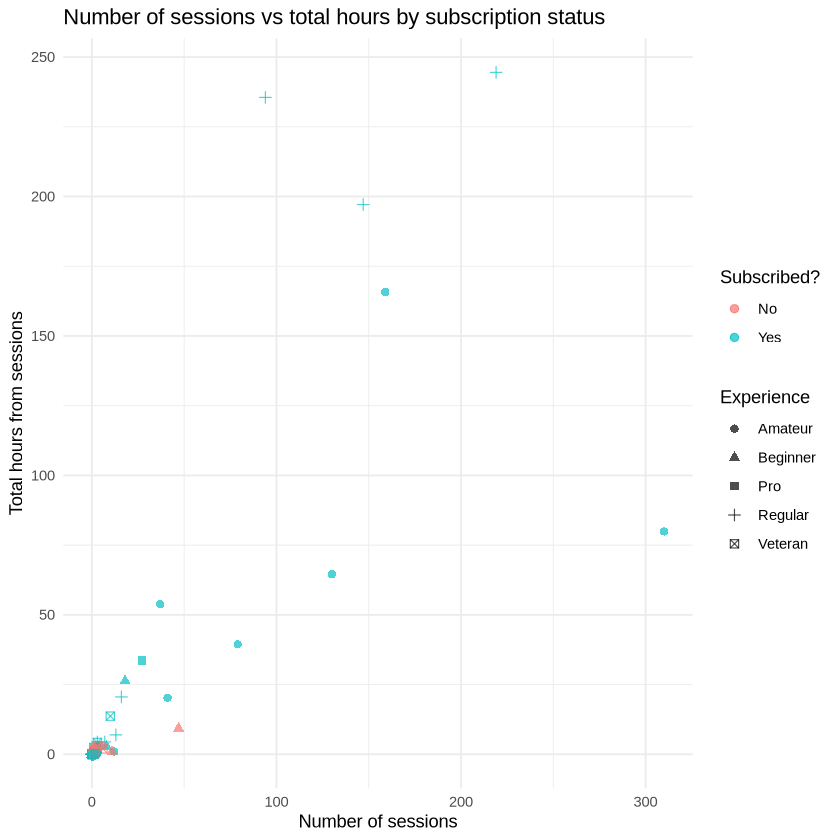

In [56]:
# 4.8 Session count vs total hours
sessions_vs_total_hours_plot <-
  player_df |>
  ggplot(
    aes(
      x      = n_sessions,
      y      = total_hours,
      colour = subscribe,
      shape  = experience
    )
  ) +
  geom_point(alpha = 0.7, size = 2) +
  labs(
    title  = "Number of sessions vs total hours by subscription status",
    x      = "Number of sessions",
    y      = "Total hours from sessions",
    colour = "Subscribed?",
    shape  = "Experience"
  ) +
  theme_minimal()
sessions_vs_total_hours_plot

Rows: 194
Columns: 4
$ age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ total_hours  <dbl> 33.65000000, 4.25000000, 0.08333333, 0.83333333, 0.150000…
$ n_sessions   <int> 27, 3, 1, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 0, 0, 0, 37, 2…


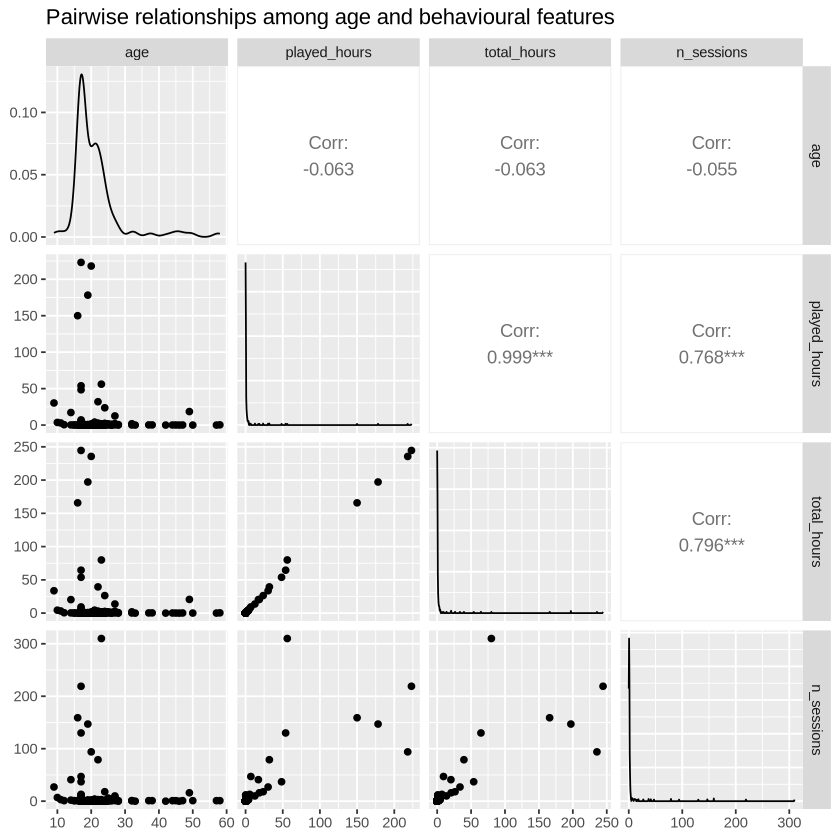

In [57]:
# 4.9 Pairwise numeric relationships

behaviour_vars <-
  player_df |>
  select(age, played_hours, total_hours, n_sessions) |>
  drop_na()
glimpse(behaviour_vars) 

pairwise_behaviour_plot <-
  ggpairs(
    behaviour_vars,
    title = "Pairwise relationships among age and behavioural features"
  )
pairwise_behaviour_plot

5. KNN classification: predicting subscription

We now build a K-nearest neighbours (KNN) classifier to predict newsletter subscription from player characteristics and behaviour.

In [58]:
# 5. KNN classification
## using tidymodels and tuning K by cross-validation


## 5.1 Prepare modelling data

player_model_data <-
  player_df |>
  select(
    subscribe, # factor: "No"/"Yes"
    age,
    played_hours,
    total_hours,
    n_sessions,
    avg_session_minutes,
    sessions_per_day
  ) |>
  drop_na()

# Check balance
player_model_data |>
  count(subscribe)

subscribe n 
1 No        32
2 Yes       91

In [59]:
# 5.2 Train/test split (75% train, 25% test) 

set.seed(123)
player_split <- initial_split(player_model_data,
                              prop   = 0.75,
                              strata = subscribe)

player_train <- training(player_split)
player_test  <- testing(player_split)

In [60]:
# 5.3 Recipe: center & scale predictors

player_recipe <-
  recipe(subscribe ~ age + played_hours + total_hours +
           n_sessions + avg_session_minutes + sessions_per_day,
         data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [61]:
# 5.4 KNN model spec (with K to be tuned)

knn_spec <-
  nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = tune()        
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

In [62]:
# 5.5 Cross-validation folds on training data

set.seed(123)
player_vfold <- vfold_cv(player_train, v = 10, strata = subscribe)

[1] 21

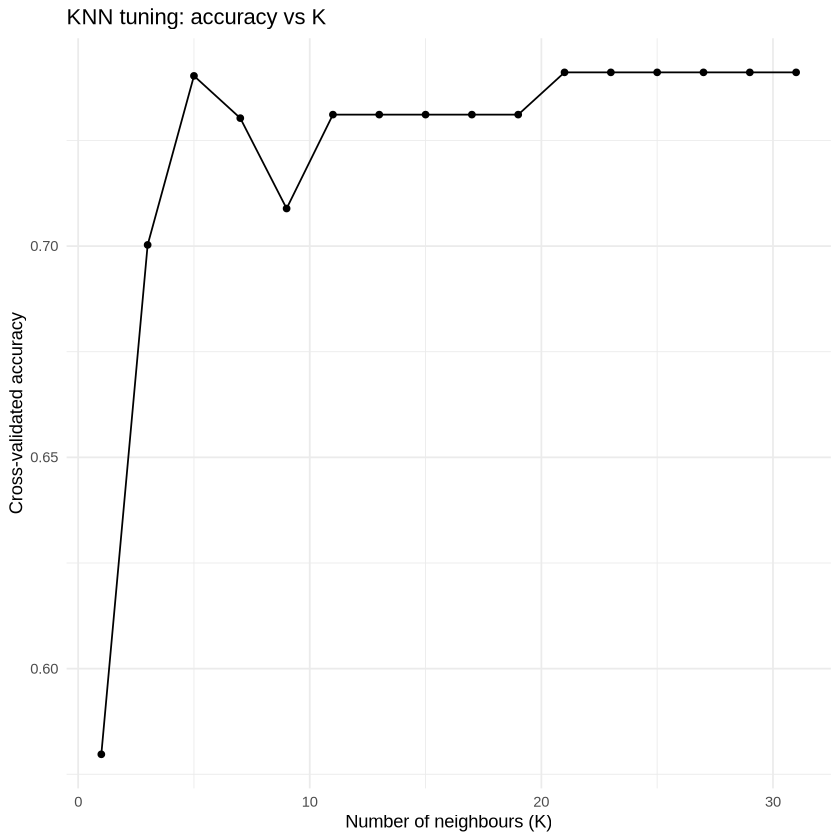

In [63]:
## 5.6 Grid of K values to try and tuning ------------------
## Our training folds have ~80 rows, so we keep K << 80
## to avoid k issues in kknn.

k_grid <- tibble(
  neighbors = seq(from = 1, to = 31, by = 2) 
)

knn_tune_results <-
  workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  tune_grid(
    resamples = player_vfold,
    grid      = k_grid
    )

# Extract only accuracy rows
knn_accuracies <-
  knn_tune_results |>
  collect_metrics() |>
  filter(.metric == "accuracy")

# Plot accuracy vs K
ggplot(knn_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(
    x = "Number of neighbours (K)",
    y = "Cross-validated accuracy",
    title = "KNN tuning: accuracy vs K"
  ) +
  theme_minimal()

# Best K based on mean CV accuracy
best_k <-
  knn_accuracies |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

best_k


In [64]:
# 5.7 Final KNN model with best K

knn_final_spec <-
  nearest_neighbor(
    weight_func = "rectangular",
    neighbors   = best_k
  ) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_final_fit <-
  workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_final_spec) |>
  fit(data = player_train)


In [65]:
# 5.8 Evaluate on test set

player_test_predictions <-
  predict(knn_final_fit, player_test) |>
  bind_cols(player_test)

# Overall accuracy
knn_test_metrics <-
  player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)
knn_test_metrics

knn_test_accuracy <-
  knn_test_metrics |>
  filter(.metric == "accuracy") |>
  pull(.estimate)
knn_test_accuracy

# Confusion matrix
knn_conf_mat <-
  player_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)
knn_conf_mat

.metric  .estimator .estimate
1 accuracy binary     0.7419355
2 kap      binary     0.0000000

[1] 0.7419355

          Truth
Prediction No Yes
       No   0   0
       Yes  8  23

6. Clustering players into behavioural “types”

Next, we use k-means clustering to group players into “behavioural types” based on their activity patterns, and then examine how subscription and data contribution differ across clusters. This will allow us to make better inferences with our data rather than with just KNN classification alone.

In [66]:
# 6. Clustering players into behavioural "kinds" or "types"

# Behavioural characteristics:
# - played_hours
# - total_hours
# - n_sessions
# - avg_session_minutes
# - sessions_per_day

cluster_data <-
  player_df |>
  select(hashed_email,
    subscribe,
    experience,
    played_hours,
    total_hours,
    n_sessions,
    avg_session_minutes,
    sessions_per_day
  ) |>
  drop_na(played_hours,
    total_hours,
    n_sessions,
    avg_session_minutes,
    sessions_per_day
  )
glimpse(cluster_data)

Rows: 125
Columns: 8
$ hashed_email        <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0e…
$ subscribe           <fct> Yes, Yes, No, Yes, Yes, No, Yes, Yes, Yes, Yes, Ye…
$ experience          <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateur, …
$ played_hours        <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.1, 1.6, 1.5, 0.2,…
$ total_hours         <dbl> 33.65000000, 4.25000000, 0.08333333, 0.83333333, 0…
$ n_sessions          <int> 27, 3, 1, 1, 1, 1, 1, 3, 1, 1, 37, 2, 2, 1, 1, 2, …
$ avg_session_minutes <dbl> 74.77778, 85.00000, 5.00000, 50.00000, 9.00000, 5.…
$ sessions_per_day    <dbl> 1.500000, 1.500000, 1.000000, 1.000000, 1.000000, …


num_clusters total_WSSD
1 1            620.00000 
2 2            285.28891 
3 3            198.29646 
4 4            125.74464 
5 5             82.35081 
6 6             66.46583 
7 7             56.74076 
8 8             45.36868 
9 9             40.15288

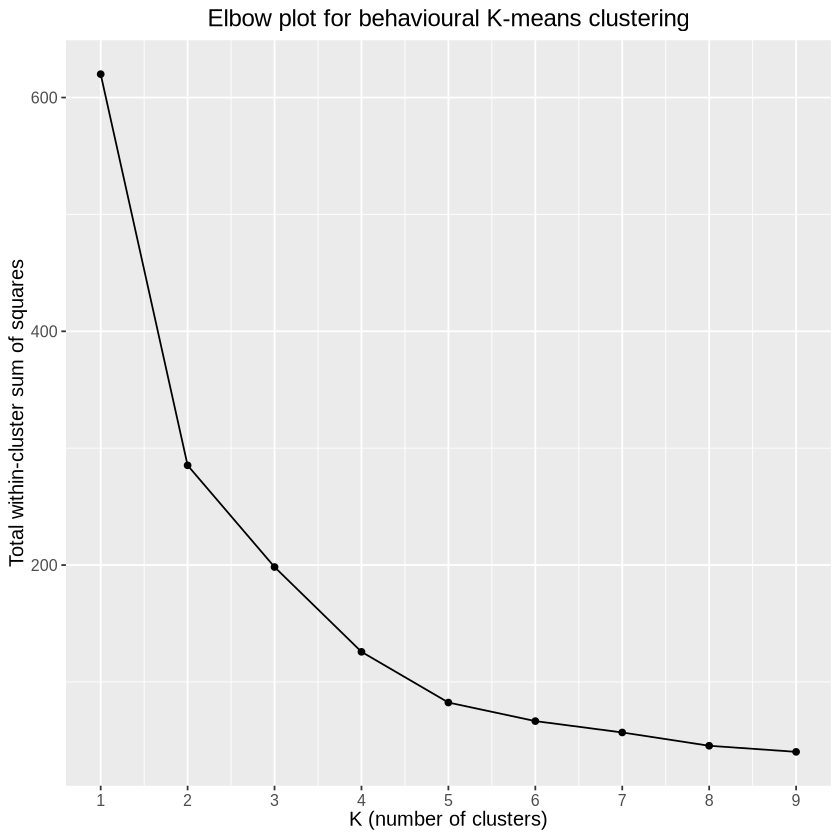

In [67]:
# 6.1 Recipe: scale + center behavioural predictors

kmeans_recipe <-
  recipe(
    ~ played_hours + total_hours + n_sessions +
      avg_session_minutes + sessions_per_day,
    data = cluster_data
  ) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# 6.2 K-means spec with K to tune

kmeans_spec <-
  k_means(num_clusters = tune()) |>
  set_engine("stats", nstart = 25)

# 6.3 Grid of cluster numbers and tuning for elbow

cluster_ks <- tibble(num_clusters = 1:9)

kmeans_results <-
  workflow() |>
  add_recipe(kmeans_recipe) |>
  add_model(kmeans_spec) |>
  tune_cluster(
    resamples = apparent(cluster_data),
    grid      = cluster_ks
  ) |>
  collect_metrics() |>
  filter(.metric == "sse_within_total") |>
  mutate(total_WSSD = mean) |>
  select(num_clusters, total_WSSD)
kmeans_results

# Elbow plot

elbow_plot <-
  ggplot(kmeans_results,
         aes(x = num_clusters, y = total_WSSD)) +
  geom_point() +
  geom_line() +
  scale_x_continuous(breaks = 1:9) +
  xlab("K (number of clusters)") +
  ylab("Total within-cluster sum of squares") +
  ggtitle("Elbow plot for behavioural K-means clustering") +
  theme(text = element_text(size = 12),
        plot.title = element_text(hjust = 0.5))

elbow_plot

In [68]:
k_chosen <- 4

In [69]:
# 6.5 Final K-means with chosen K

kmeans_final_spec <-
  k_means(num_clusters = k_chosen) |>
  set_engine("stats", nstart = 25)

kmeans_final_fit <-
  workflow() |>
  add_recipe(kmeans_recipe) |>
  add_model(kmeans_final_spec) |>
  fit(data = cluster_data)

# Add cluster labels back to the data
clustered_data <-
  kmeans_final_fit |>
  augment(cluster_data) |>
  rename(cluster = .pred_cluster)
clustered_data

# Merge cluster labels into full player_df
players_clustered <-
  player_df |>
  left_join(
    clustered_data |>
      select(hashed_email, cluster),
    by = "hashed_email"
  )
players_clustered

cluster   hashed_email                                                    
1   Cluster_1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   Cluster_1 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   Cluster_2 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
4   Cluster_2 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5
5   Cluster_2 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e
6   Cluster_2 1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd
7   Cluster_2 8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1
8   Cluster_2 7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875
9   Cluster_1 4bed6f49b672974f706aa7f020b4f29020326bf594520593557cd381a51559b8
10  Cluster_2 3caa832978e0596779f4ee7c686c4592fb6de893925025d25bf26be9a8cd03f5
11  Cluster_1 a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e
12  Cluster_2 ab1f44f93c3b828f55458971db393052d9711df3e0e7ff69540bfebfcec555ff
13  Cluster_3 20ae3f8b5323674fe6e537bc91928841cfc2a00c1b36522fd25370bb6fa89d36
14  Cluster_2 bc704ff2bc676dbf48ee41b9e11481c1387bf758ad318f2428f336e3fecc6660
15  Cluster_2 200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687
16  Cluster_3 f9ac013b2f0bc2bd4928a6a0fc8a0aae8b5c4f2670cf9e18f547b7e72034c965
17  Cluster_2 119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760
18  Cluster_2 5baba1651a0b92788bc0d6dcdf00be64af1cf9f0015bbeed204ddabd1d872e83
19  Cluster_1 4b01bce3f141289709e8278b02ba5d2aaa7105d7ccb9c7deb37670a80e332774
20  Cluster_2 951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd
21  Cluster_2 710148466b44cb02ba894aa9005a4892e619250ebd01153055d6c7578fc1ea10
22  Cluster_2 f1b432523542f90c61176a555ccb2144468d76c91a32d74082ab8c101f9d25b6
23  Cluster_3 f459ce1862ec9a43b6c714810390dfd632ed104eb11378b3a2a134b1b107bc75
24  Cluster_2 5a340c0e3d1aa3e579efc625bd3e5bca7fc25f7115b68e9411f457464bfd3df4
25  Cluster_2 88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62
26  Cluster_3 e3e1bef1ce259c995332635c0ec630a575713451cbe742d7ca93e4c03d0826df
27  Cluster_3 0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3
28  Cluster_2 d07befbac08be3d876d026ac0458651067001b39081d24724af3c95be76355e0
29  Cluster_2 75f275366c0dbb8b23957b97aaaf77db5d6517fb846d3d4d209bd391ae3d39f6
30  Cluster_1 8d2eed1f399e0d77cebb8fcc48ed19ad2fa8e3bb3fa683cb90e0ac6d42677bf2
⋮   ⋮         ⋮                                                               
96  Cluster_2 0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387
97  Cluster_2 22a78bfd44e46931261d06864b92cf9a8fd77fb02bec66cb71646dd9da222a0d
98  Cluster_2 8af6e04a9067b009303e36cf39f7e7d53f9473e74b4633876ddd79769158b665
99  Cluster_2 7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d
100 Cluster_4 ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83
101 Cluster_2 f4f29f2465743ead8c3ce02fc84542afe33ae3c95ef56a42b8f7785550fe9e4a
102 Cluster_2 d43af3bed5e9f1f31077233697c18f3f988a217bd0376a5f1a54d14964a38c36
103 Cluster_2 c121e4d197469bea90e21c0495001f4e21824adb98cbc6a40d54e66617cee174
104 Cluster_3 7096b30972a32029244fc6171f21bc5996b51b8d75df7a94f003dead428988f9
105 Cluster_3 42eafe96ed5c1684e3b5cc614d1b01a117173d3ec6898abcf1177d9822bd39f7
106 Cluster_2 9ba67e127e4e70d909f6237644bb4674b17bc6ae5c9e735f88cfc50e22b499c6
107 Cluster_2 4bfad3613c71ace05644bf210195d9fb0d3d9513753ad2f8a16d1a80699bb906
108 Cluster_2 060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967
109 Cluster_1 80afc8e7137de6a232421e926c1e6e64ddeef1d8157c4439746bc00fcf91e8a7
110 Cluster_2 7b17513f11968feaf6b02977885c436dc2a4549489ca25ef03022f9fbae19d81
111 Cluster_3 55d24216db39c27e1f17cc43d3127cbf8ed76ada6d098202b53ded319855e2c1
112 Cluster_1 a1e0438d568b9c05a93cadaf99969e4d44794d19dea31edd723cbc916f878c33
113 Cluster_2 9955ab948064150d3686ef564389bdc6d6c60bc620a5ce3084b3dec4a7a006a7
114 Cluster_2 6b1cdc07fcc1f7ea09509341fd245dd34fdba386

experience subscribe
1   Pro        Yes      
2   Veteran    Yes      
3   Veteran    No       
4   Amateur    Yes      
5   Regular    Yes      
6   Amateur    Yes      
7   Regular    Yes      
8   Amateur    No       
9   Amateur    Yes      
10  Veteran    Yes      
11  Veteran    Yes      
12  Pro        Yes      
13  Beginner   Yes      
14  Amateur    Yes      
15  Veteran    Yes      
16  Amateur    No       
17  Beginner   Yes      
18  Amateur    Yes      
19  Amateur    Yes      
20  Regular    Yes      
21  Regular    Yes      
22  Amateur    No       
23  Beginner   Yes      
24  Beginner   Yes      
25  Amateur    Yes      
26  Regular    Yes      
27  Regular    Yes      
28  Veteran    No       
29  Amateur    Yes      
30  Veteran    No       
⋮   ⋮          ⋮        
167 Amateur    No       
168 Beginner   No       
169 Veteran    Yes      
170 Veteran    No       
171 Pro        No       
172 Beginner   No       
173 Veteran    Yes      
174 Regular    No       
175 Veteran    Yes      
176 Amateur    Yes      
177 Pro        No       
178 Veteran    No       
179 Amateur    Yes      
180 Veteran    Yes      
181 Amateur    No       
182 Amateur    Yes      
183 Pro        No       
184 Amateur    Yes      
185 Pro        No       
186 Regular    No       
187 Veteran    Yes      
188 Amateur    Yes      
189 Beginner   Yes      
190 Amateur    No       
191 Amateur    Yes      
192 Amateur    Yes      
193 Veteran    No       
194 Amateur    No       
195 Amateur    No       
196 Pro        Yes      
    hashed_email                                                    
1   f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
2   f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
3   b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
4   23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5
5   7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e
6   f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977
7   8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807
8   1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd
9   8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1
10  bbe2d83de678f519c4b3daa7265e683b4fe2d814077f9094afd11d8f217039ec
11  7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875
12  4caa42e1b20511552434978171dcf7283fb6eb857eb871327e39bfc328002309
13  4bed6f49b672974f706aa7f020b4f29020326bf594520593557cd381a51559b8
14  3caa832978e0596779f4ee7c686c4592fb6de893925025d25bf26be9a8cd03f5
15  6f9acf8ea9956fe817895c78d10e1e25c11aba335a451e5b0322b073ee5008c4
16  2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53
17  9db37a1d381697f6c83e3b97b276e38bb9d9c811ba4596edb75d4dbfea6415b0
18  a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e
19  ab1f44f93c3b828f55458971db393052d9711df3e0e7ff69540bfebfcec555ff
20  20ae3f8b5323674fe6e537bc91928841cfc2a00c1b36522fd25370bb6fa89d36
21  bc704ff2bc676dbf48ee41b9e11481c1387bf758ad318f2428f336e3fecc6660
22  200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687
23  f9ac013b2f0bc2bd4928a6a0fc8a0aae8b5c4f2670cf9e18f547b7e72034c965
24  89c8e07d6a2aa102d9cd05086d51b2e41195c9c807dd976a06f4262ff36d0cca
25  119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760
26  5baba1651a0b92788bc0d6dcdf00be64af1cf9f0015bbeed204ddabd1d872e83
27  50cec73a632e4be7b155c3df5165de28b2c5baf092abcb7f509f5645776a56c2
28  f8acd26a5e452b682b9f8b20108caef1ee2e745efe08e95806980bd2388a3fea
29  4b01bce3f141289709e8278b02ba5d2aaa7105d7ccb9c7deb37670a80e332774
30  951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd
⋮   ⋮                                                               
167 7096b30972a32029244fc6171f21bc5996b51b8d75df7a94f003dead428988f9
168 42eafe96ed5c1684e3b5cc614d1b01a117173d3ec6898abcf1177d9822bd39f7
169 9ba67e127e4e70d909f6237644bb4674b17bc6ae5c9e735f88cfc50e22b499c6
170 4bfad3613c71ace05644bf210195d9fb0d3

# Choosing the number of clusters (K)

The elbow plot of total within–cluster sum of squares (WSSD) as a function of K
shows a steep decrease from K = 1 to K = 4, and much smaller improvements after.

Therefore, we chose K = 4 as a balance.

The four resulting clusters correspond roughly to:
1. Light players,
2. Moderately engaged players,
3. Session-heavy players,
4. Extremely heavy engaged players,
which aligns well with intuitive behavioural categories in online games.


7: Visualizing clusters & their contribution to data

We now summarize each cluster in terms of:

Number of players

Subscription rate

Total play time

Number of sessions

Average behaviour

In [70]:
# 7.1 Cluster-level summaries

cluster_summary <-
  players_clustered |>
  filter(!is.na(cluster)) |>
  group_by(cluster) |>
  summarise(
    n_players                = n(),
    subscribe_rate           = mean(subscribe == "Yes", na.rm = TRUE),
    total_minutes_cluster    = sum(total_minutes, na.rm = TRUE),
    total_sessions_cluster   = sum(n_sessions, na.rm = TRUE),
    mean_played_hours        = mean(played_hours, na.rm = TRUE),
    mean_total_hours         = mean(total_hours, na.rm = TRUE),
    mean_avg_session_minutes = mean(avg_session_minutes, na.rm = TRUE),
    mean_sessions_per_day    = mean(sessions_per_day, na.rm = TRUE),
    .groups                  = "drop"
  ) |>
  mutate(
    share_of_minutes   = total_minutes_cluster / sum(total_minutes_cluster),
    share_of_sessions  = total_sessions_cluster / sum(total_sessions_cluster),
    subscribe_rate_pct = subscribe_rate * 100
  )
cluster_summary

cluster   n_players subscribe_rate total_minutes_cluster
1 Cluster_1 24        0.7500000      11392                
2 Cluster_2 82        0.7317073       2129                
3 Cluster_3 14        0.7142857       9073                
4 Cluster_4  5        1.0000000      55372                
  total_sessions_cluster mean_played_hours mean_total_hours
1 141                      7.1416667         7.9111111     
2 111                      0.3146341         0.4327236     
3 352                      8.7928571        10.8011905     
4 929                    165.1000000       184.5733333     
  mean_avg_session_minutes mean_sessions_per_day share_of_minutes
1 82.78819                 1.174833              0.14611497      
2 16.61585                 1.008943              0.02730677      
3 24.19217                 2.237524              0.11637124      
4 75.16291                 2.197269              0.71020701      
  share_of_sessions subscribe_rate_pct
1 0.09197652         75.00000         
2 0.07240705         73.17073         
3 0.22961513         71.42857         
4 0.60600130        100.00000

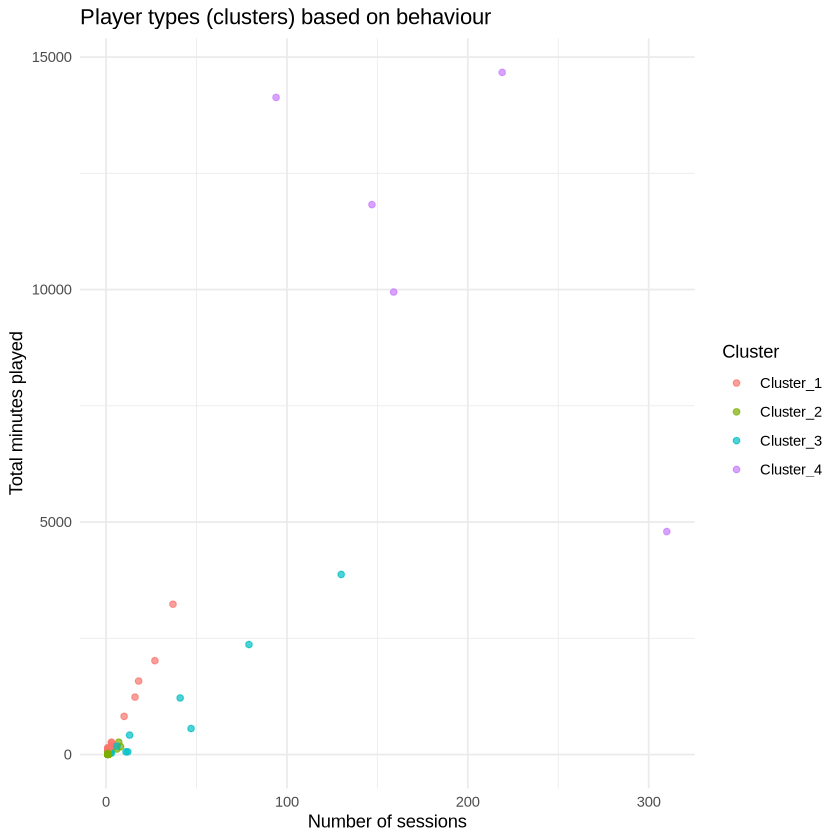

In [71]:
# 7.2 Scatter of behaviour by cluster

players_clustered |>
  filter(!is.na(cluster)) |>
  ggplot(aes(x = n_sessions,
             y = total_minutes,
             colour = cluster)) +
  geom_point(alpha = 0.7) +
  labs(
    title = "Player types (clusters) based on behaviour",
    x     = "Number of sessions",
    y     = "Total minutes played",
    colour = "Cluster"
  ) +
  theme_minimal()

cluster   n_players subscribe_rate total_minutes_cluster
1 Cluster_1 24        0.7500000      11392                
2 Cluster_2 82        0.7317073       2129                
3 Cluster_3 14        0.7142857       9073                
4 Cluster_4  5        1.0000000      55372                
  total_sessions_cluster mean_played_hours mean_total_hours
1 141                      7.1416667         7.9111111     
2 111                      0.3146341         0.4327236     
3 352                      8.7928571        10.8011905     
4 929                    165.1000000       184.5733333     
  mean_avg_session_minutes mean_sessions_per_day share_of_minutes
1 82.78819                 1.174833              0.14611497      
2 16.61585                 1.008943              0.02730677      
3 24.19217                 2.237524              0.11637124      
4 75.16291                 2.197269              0.71020701      
  share_of_sessions subscribe_rate_pct
1 0.09197652         75.00000         
2 0.07240705         73.17073         
3 0.22961513         71.42857         
4 0.60600130        100.00000

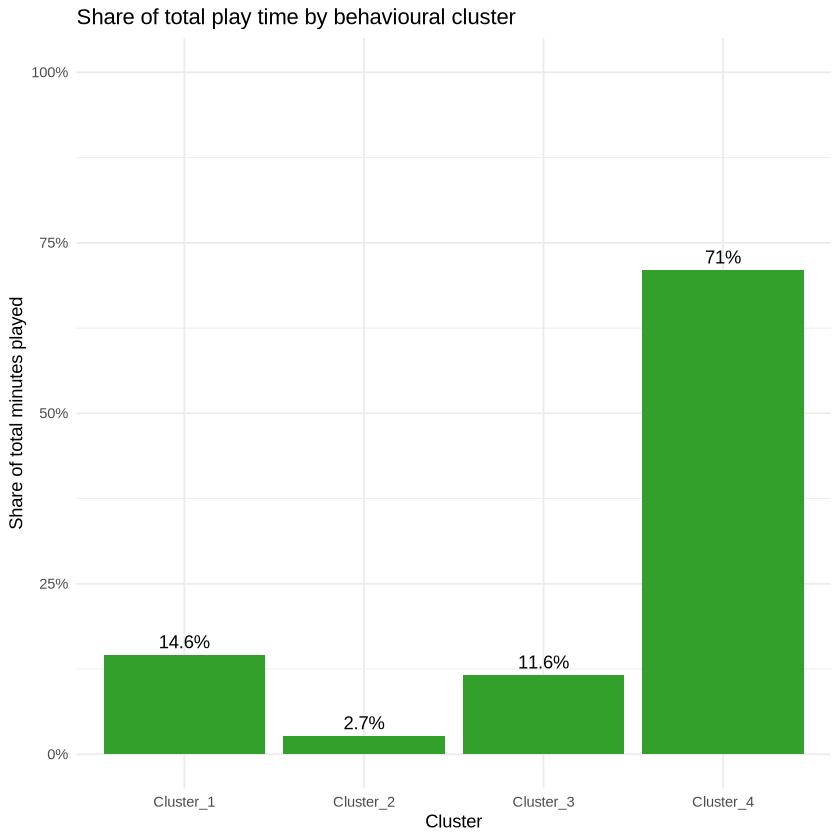

cluster   n_players subscribe_rate total_minutes_cluster
1 Cluster_1 24        0.7500000      11392                
2 Cluster_2 82        0.7317073       2129                
3 Cluster_3 14        0.7142857       9073                
4 Cluster_4  5        1.0000000      55372                
  total_sessions_cluster mean_played_hours mean_total_hours
1 141                      7.1416667         7.9111111     
2 111                      0.3146341         0.4327236     
3 352                      8.7928571        10.8011905     
4 929                    165.1000000       184.5733333     
  mean_avg_session_minutes mean_sessions_per_day share_of_minutes
1 82.78819                 1.174833              0.14611497      
2 16.61585                 1.008943              0.02730677      
3 24.19217                 2.237524              0.11637124      
4 75.16291                 2.197269              0.71020701      
  share_of_sessions subscribe_rate_pct
1 0.09197652         75.00000         
2 0.07240705         73.17073         
3 0.22961513         71.42857         
4 0.60600130        100.00000

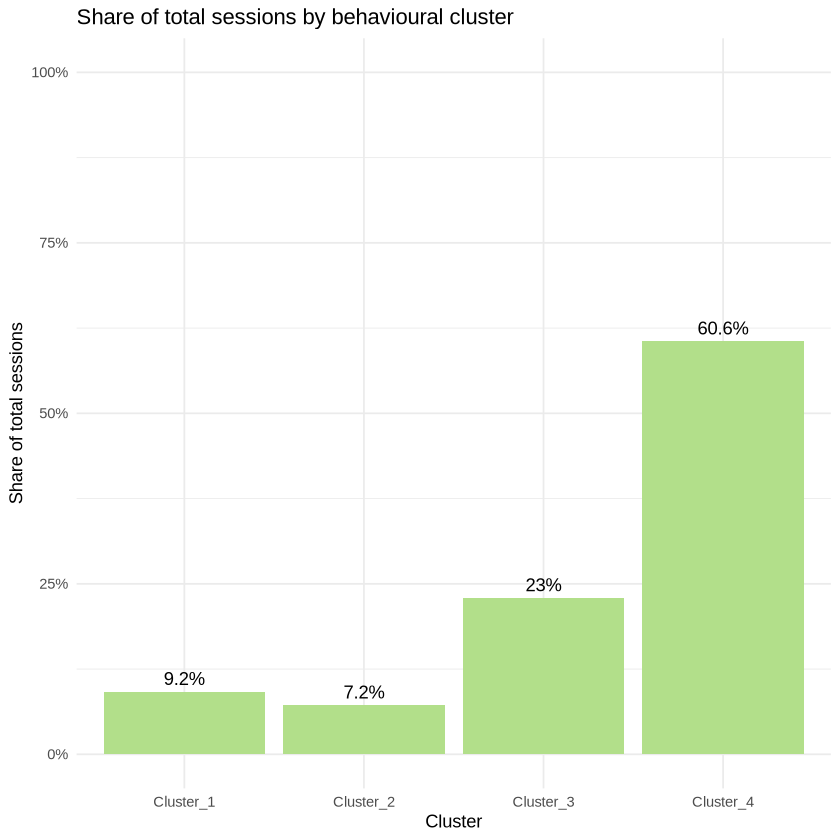

cluster   n_players subscribe_rate total_minutes_cluster
1 Cluster_1 24        0.7500000      11392                
2 Cluster_2 82        0.7317073       2129                
3 Cluster_3 14        0.7142857       9073                
4 Cluster_4  5        1.0000000      55372                
  total_sessions_cluster mean_played_hours mean_total_hours
1 141                      7.1416667         7.9111111     
2 111                      0.3146341         0.4327236     
3 352                      8.7928571        10.8011905     
4 929                    165.1000000       184.5733333     
  mean_avg_session_minutes mean_sessions_per_day share_of_minutes
1 82.78819                 1.174833              0.14611497      
2 16.61585                 1.008943              0.02730677      
3 24.19217                 2.237524              0.11637124      
4 75.16291                 2.197269              0.71020701      
  share_of_sessions subscribe_rate_pct
1 0.09197652         75.00000         
2 0.07240705         73.17073         
3 0.22961513         71.42857         
4 0.60600130        100.00000

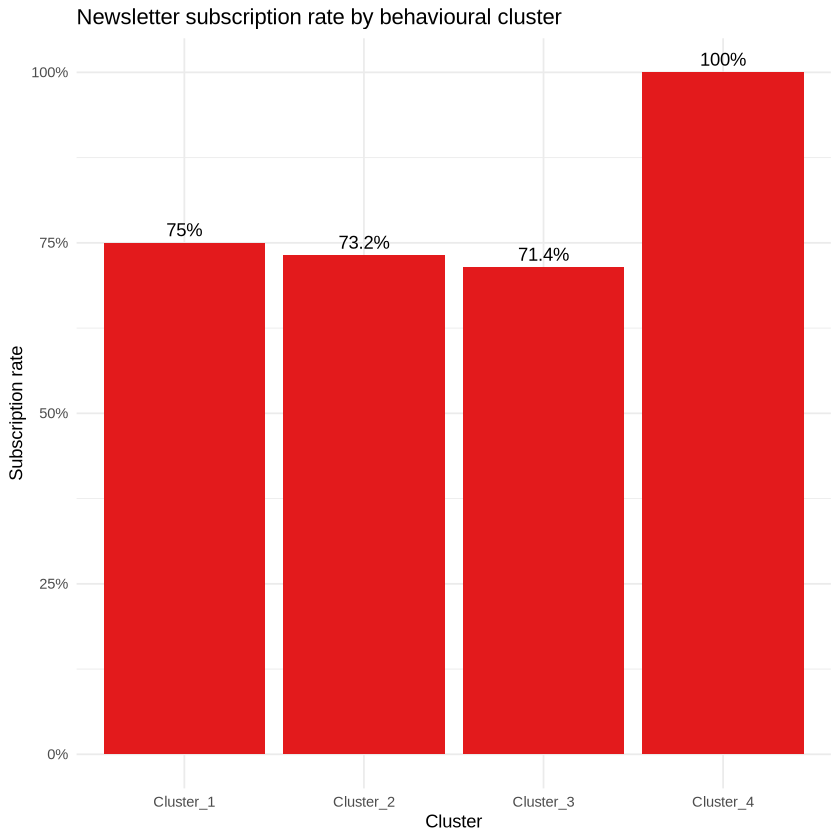

In [72]:
# 7.3 Which clusters contribute most data?

# (A) Share of total minutes played by cluster
cluster_summary |>
  ggplot(aes(x = cluster, y = share_of_minutes)) +
  geom_col(fill = "#33a02c") +
  geom_text(
    aes(label = paste0(round(share_of_minutes * 100, 1), "%")),
    vjust = -0.5,
    colour = "black"
  ) +
  scale_y_continuous(
    labels = function(x) paste0(x * 100, "%"),
    limits = c(0, 1)
  ) +
  labs(
    title = "Share of total play time by behavioural cluster",
    x     = "Cluster",
    y     = "Share of total minutes played"
  ) +
  theme_minimal()
cluster_summary

# (B) Share of total sessions by cluster
cluster_summary |>
  ggplot(aes(x = cluster, y = share_of_sessions)) +
  geom_col(fill = "#b2df8a") +
  geom_text(
    aes(label = paste0(round(share_of_sessions * 100, 1), "%")),
    vjust = -0.5,
    colour = "black"
  ) +
  scale_y_continuous(
    labels = function(x) paste0(x * 100, "%"),
    limits = c(0, 1)
  ) +
  labs(
    title = "Share of total sessions by behavioural cluster",
    x     = "Cluster",
    y     = "Share of total sessions"
  ) +
  theme_minimal()
cluster_summary
# (C) Subscription rate by cluster
cluster_summary |>
  ggplot(aes(x = cluster, y = subscribe_rate)) +
  geom_col(fill = "#e31a1c") +
  geom_text(
    aes(label = paste0(round(subscribe_rate * 100, 1), "%")),
    vjust = -0.5,
    colour = "black"
  ) +
  scale_y_continuous(
    labels = function(x) paste0(x * 100, "%"),
    limits = c(0, 1)
  ) +
  labs(
    title = "Newsletter subscription rate by behavioural cluster",
    x     = "Cluster",
    y     = "Subscription rate"
  ) +
  theme_minimal()
cluster_summary

test